In [1]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

import imutils

In [2]:
def url_to_image(url):
  print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

def imshow(np_img, size=(10, 10), is_gray=False):
    plt.figure(figsize=size)
    if is_gray:
        plt.imshow(np_img, cmap='gray', vmin=0, vmax=255)
    else:
        try:
            plt.imshow(cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB))
        except:
            plt.imshow(np_img)
    plt.show()

# Separate text from background and denoise

In [3]:
text1_url = 'https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/text1.jpg'
text2_url = 'https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/text2.jpg'
text3_url = 'https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/text3.jpg'

text_urls = [text1_url, text2_url, text3_url]

text_images = [url_to_image(i) for i in text_urls]

downloading https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/text1.jpg
downloading https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/text2.jpg
downloading https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/text3.jpg


In [4]:
def scale_img(img, scale):
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def extract_text(img):
    # resize image 2x to better countour fill
    resized = scale_img(img, 2)

    # find edges and flip color
    grayscaled = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)

    birnary_threshold = cv2.adaptiveThreshold(grayscaled, 255,
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 27, -11)

    # dilation
    rect=cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilation = cv2.dilate(birnary_threshold,rect,iterations = 1)

    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # draw contours on the original image
    image_copy = np.zeros_like(resized)#.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255,255,255), thickness=cv2.FILLED, lineType=cv2.LINE_AA)

    image_copy = cv2.bitwise_not(image_copy)

    return scale_img(image_copy, 0.5)

  0%|          | 0/3 [00:00<?, ?it/s]

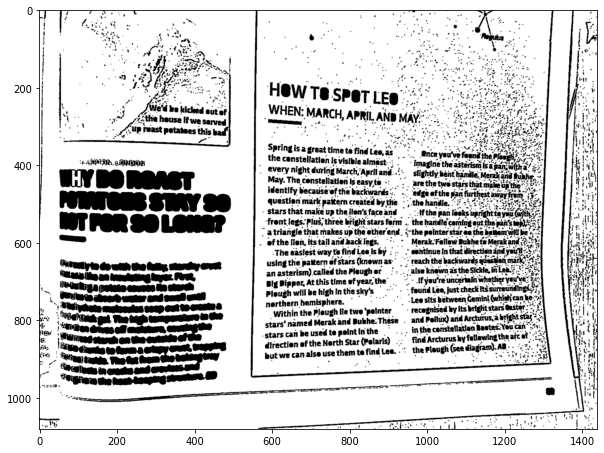

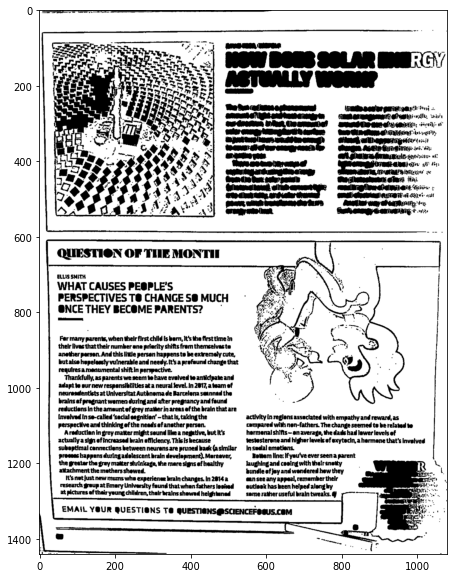

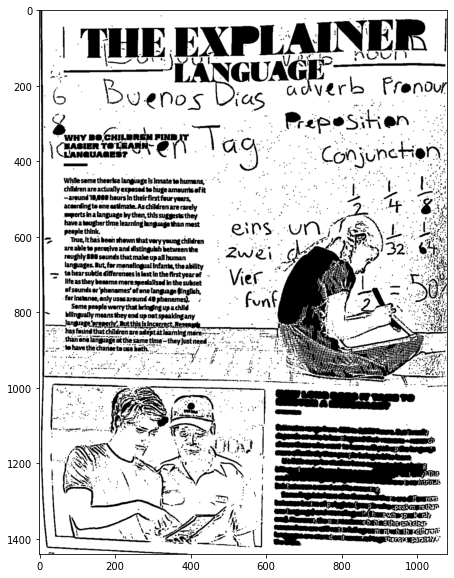

In [5]:
for img in tqdm(text_images):
    text_img = extract_text(img)
    imshow(text_img)

# Estimate number of objects

In [6]:
count1_url = 'https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/count1.jpg'
count2_url = 'https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/count2.jpg'
count3_url = 'https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/count3.jpg'

count_urls = [count1_url, count2_url, count3_url]

count_images = [url_to_image(i) for i in count_urls]

downloading https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/count1.jpg
downloading https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/count2.jpg
downloading https://github.com/mdavydov/ComputerVisionCourse/raw/master/hw2022/images/count3.jpg


In [7]:
def count_obj(img):
    shifted = cv2.pyrMeanShiftFiltering(img, 11, 21)

    grayscaled = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    edge_img = cv2.Canny(grayscaled, 100, 200)

    threshold = cv2.adaptiveThreshold(edge_img, 255,
                            cv2.BORDER_REPLICATE,
                            cv2.THRESH_BINARY, 5, 5)

    retval, birnary_threshold = cv2.threshold(threshold, 0, 255, cv2.THRESH_BINARY)

    flipped_color = cv2.bitwise_not(birnary_threshold)

    kernel = np.ones((3,3), np.uint8) 
    flipped_color = cv2.dilate(birnary_threshold, kernel, iterations=1) 

    D = ndimage.distance_transform_edt(flipped_color)

    thresh = birnary_threshold#flipped_color

    localMax = peak_local_max(D, indices=False, min_distance=7, labels=thresh)
 
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    image = img

    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
    
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(grayscaled.shape, dtype="uint8")
        mask[labels == label] = 255 
        #cv2_imshow(mask)#[labels == label] = 255   
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
        cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        

    return image, len(np.unique(labels))

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


[INFO] 85 unique segments found


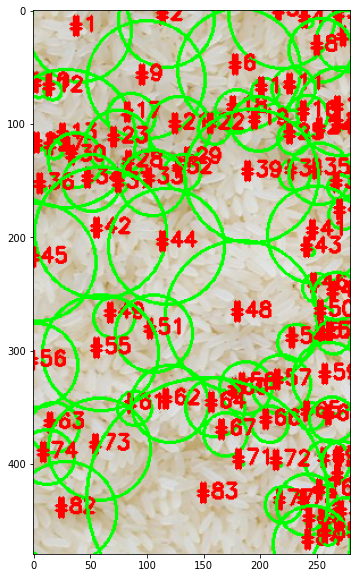

[INFO] 354 unique segments found


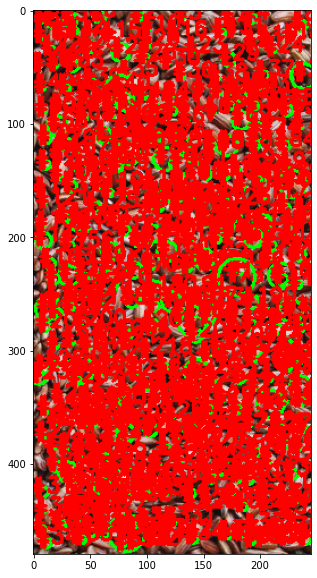

[INFO] 331 unique segments found


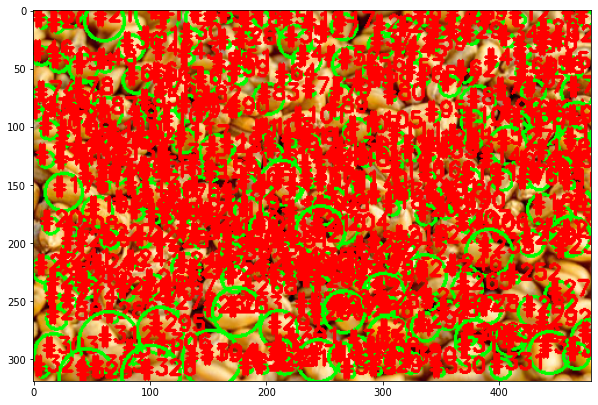

In [8]:
for img in tqdm(count_images):
    counted_img, n = count_obj(img)
    # plt.title(f"N objects: {n}")
    imshow(counted_img)

# GrabCut VS U-2-Netp

## GrabCut

In [9]:
from matplotlib import pyplot as plt
from pathlib import Path

import numpy as np

import cv2
from skimage import io

def imshow(np_img, size=(10, 10), is_gray=False):
    plt.figure(figsize=size)
    if is_gray:
        plt.imshow(np_img, cmap='gray', vmin=0, vmax=255)
    else:
        try:
            plt.imshow(cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB))
        except:
            plt.imshow(np_img)
    plt.show()

In [10]:
def remove_backhround(img_path, rect, n_iters=1):
    """
    rect - It is the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)
    """
    
    img = cv2.cvtColor(io.imread(img_path), cv2.COLOR_BGR2RGB)
    (w,h) = img.shape[:2]

    

    mask = np.zeros((w,h),np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    # cv2.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,n_iters,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_sep = img*mask2[:,:,np.newaxis]

    img_copy = img.copy()
    cv2.rectangle(img_copy, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (255,0,0), 2)
    imshow(img_copy)
    imshow(mask2*255, is_gray=True)
    imshow(img_sep)

In [11]:
base_url = 'https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/hw2022/images/'
obj1_url = base_url + 'obj1.jpg'
obj2_url = base_url + 'obj2.jpg'
obj3_url = base_url + 'obj3.jpg'

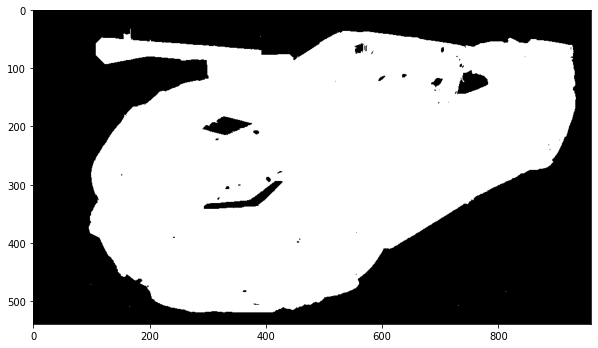

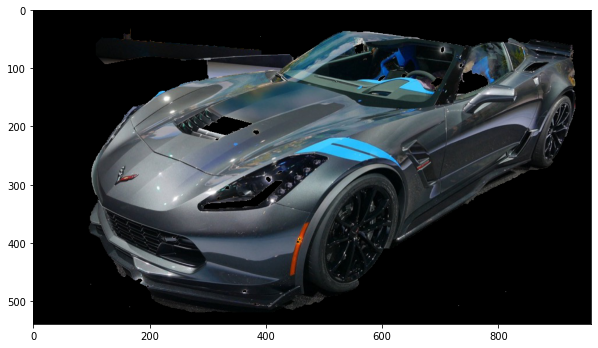

In [12]:
remove_backhround(obj1_url, (90,20, 845, 500), 30)

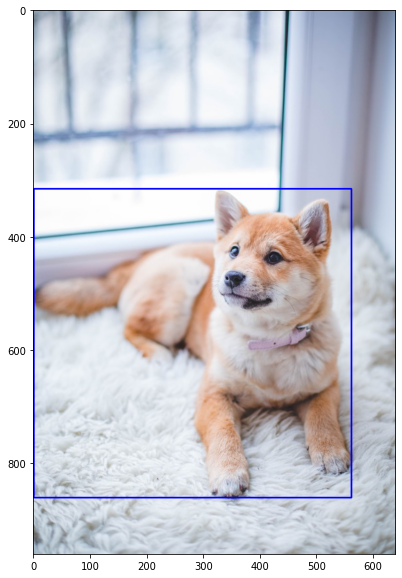

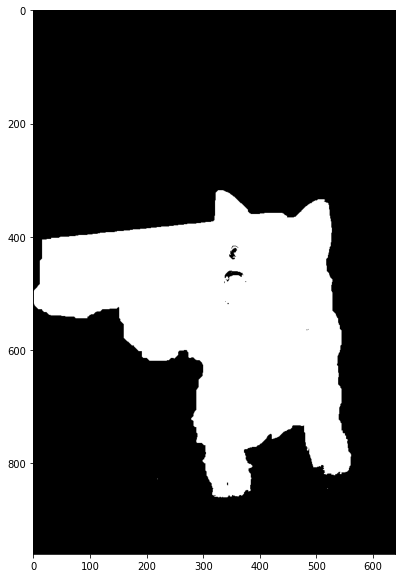

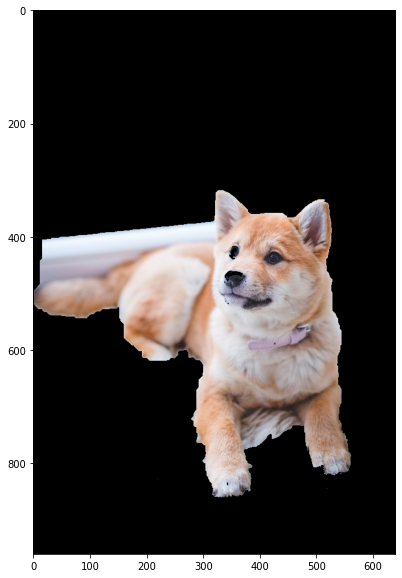

In [13]:
remove_backhround(obj2_url, (1,315, 560, 545), 15)

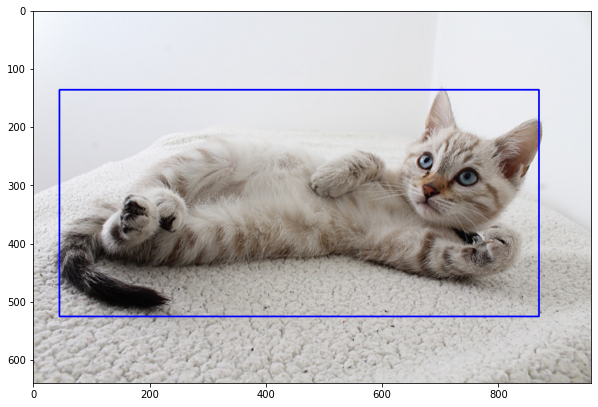

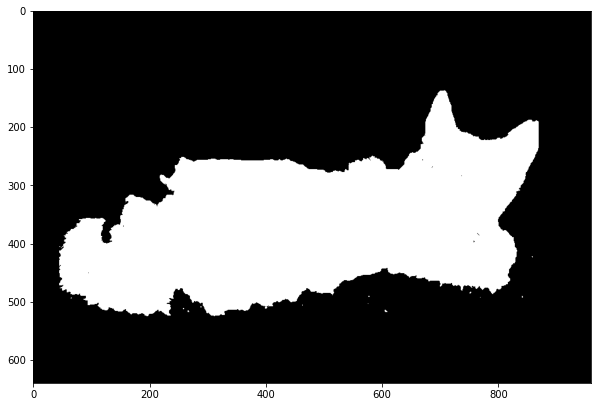

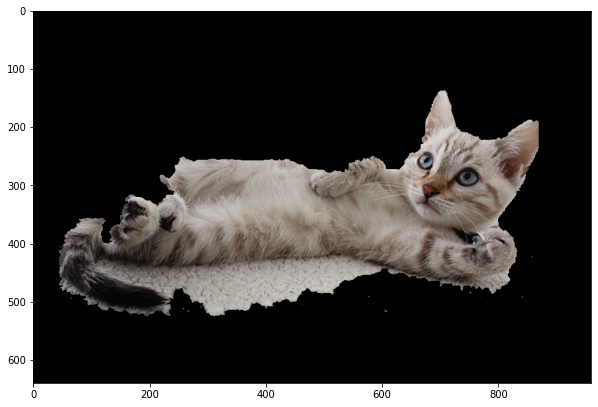

In [14]:
remove_backhround(obj3_url, (45,135, 825, 390), 13)

## U-2-Netp

In [15]:
#@title Run this cell for setups{display-mode: "form"}
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/shreyas-bk/U-2-Net
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
from google.colab.patches import cv2_imshow
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Total 520 (delta 0), reused 0 (delta 0), pack-reused 520
Receiving objects: 100% (520/520), 12.39 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/U-2-Net
making images directory
making results directory
importing...
Done!


In [16]:
#@title Run this cell to download images{display-mode: "form"}
!rm -rf /content/U-2-Net/images/*

!wget  -P /content/U-2-Net/images "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/hw2022/images/obj1.jpg"
!wget  -P /content/U-2-Net/images "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/hw2022/images/obj2.jpg"
!wget  -P /content/U-2-Net/images "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/hw2022/images/obj3.jpg"

%cd /content/U-2-Net

--2022-10-21 10:20:11--  https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/hw2022/images/obj1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174671 (171K) [image/jpeg]
Saving to: ‘/content/U-2-Net/images/obj1.jpg’

obj1.jpg            100%[===================>] 170.58K  --.-KB/s    in 0.03s   

2022-10-21 10:20:11 (5.91 MB/s) - ‘/content/U-2-Net/images/obj1.jpg’ saved [174671/174671]

--2022-10-21 10:20:11--  https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/hw2022/images/obj2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP reque

['/content/U-2-Net/images/obj3.jpg', '/content/U-2-Net/images/obj1.jpg', '/content/U-2-Net/images/obj2.jpg']
inferencing: obj3.jpg
inferencing: obj1.jpg
inferencing: obj2.jpg

INPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP



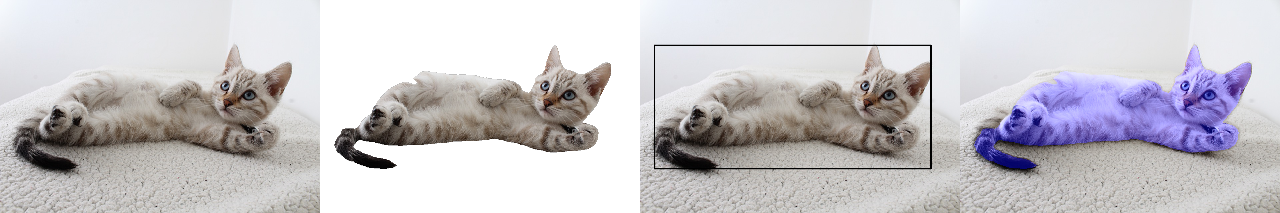


INPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP



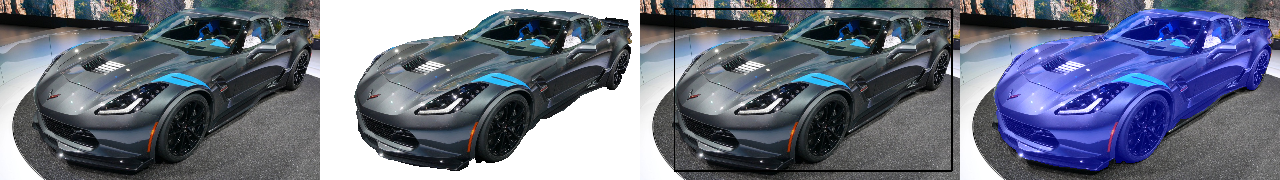


INPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP



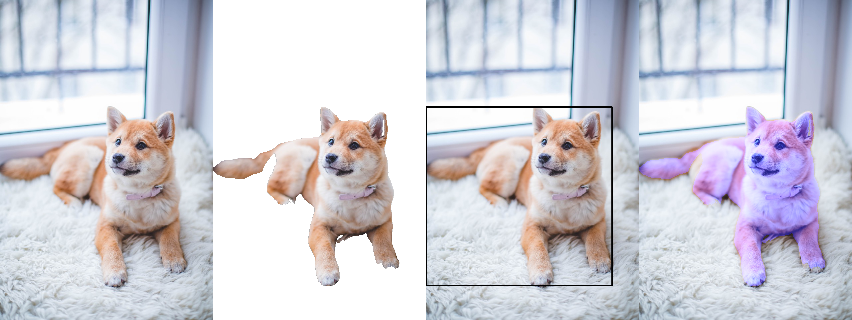

In [17]:
#@title Run this cell for results{display-mode: "form"}

# This code will be hidden when the notebook is loaded.

!python -W ignore u2net_test.py

from pathlib import Path

image_dir = Path(os.path.join(os.getcwd(), 'images'))
names = [name[:-4] for name in os.listdir(image_dir)]
THRESHOLD = 0.9
RESCALE = 255
LAYER = 2
COLOR = (0, 0, 0)
THICKNESS = 4
SAL_SHIFT = 100


for name in names:

  # BACKGROUND REMOVAL

  if name == '.ipynb_checkpo':
    continue
  output = load_img('/content/U-2-Net/results/'+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img('/content/U-2-Net/images/'+name+'.jpg')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE

  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE

  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE

  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]/3),int(shape[0]/3)))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]/3),int(shape[0]/3)))
  box_img = cv2.resize(box_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
  print('\nINPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP\n')
  display(result_img)

# Find projective transformation matrix with 4 point pairs by solving equation with 13 unknowns (H, w_1, w_2, w_3, w_4)

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/images/cvbook.jpg


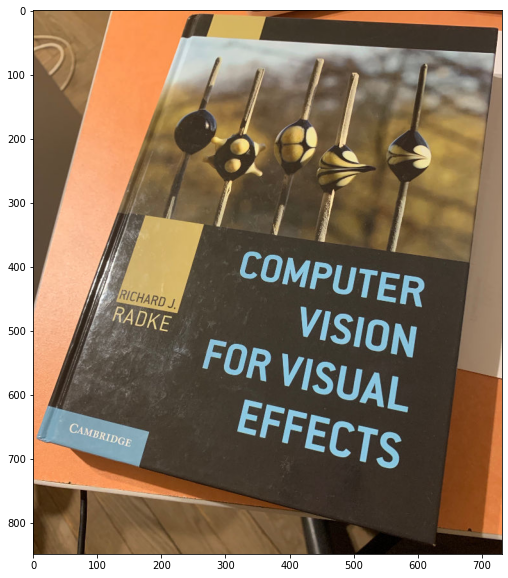

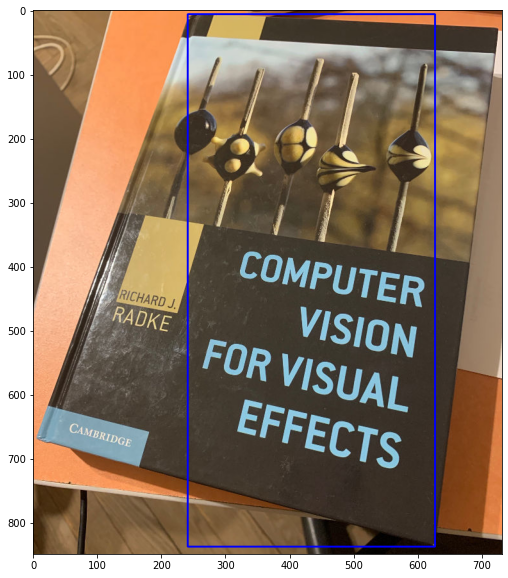

[[-4.42294919e-03 -1.57008015e-03  1.07535124e+00]
 [ 2.34342778e-04 -4.94157598e-03 -2.68271537e-02]
 [-1.78399611e-06 -3.64578167e-06 -5.86989849e-03]]


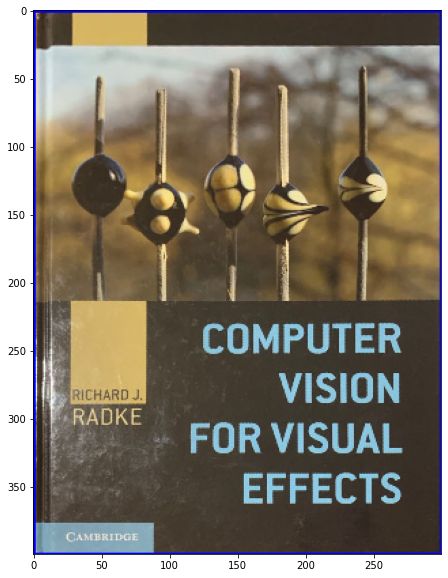

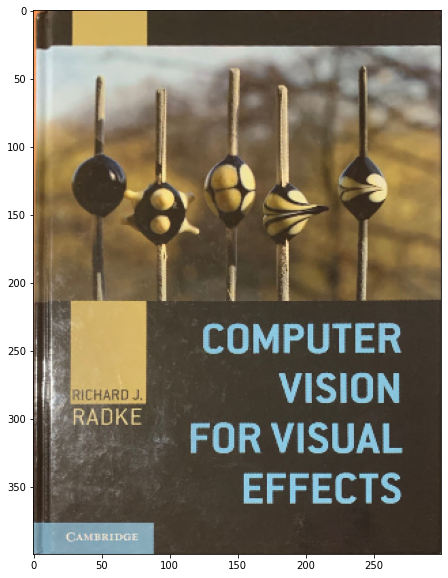

In [18]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt

def imshow(np_img, size=(10, 10), is_gray=False):
    plt.figure(figsize=size)
    if is_gray:
        plt.imshow(np_img, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB))
    plt.show()

def url_to_image(url):
    print("downloading %s" % (url))
    return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

def get_M(pts1, pts2):
    A = np.array([
        [pts1[0][0], pts1[0][1], 1, 0, 0, 0, 0, 0, 0, -pts2[0][0], 0, 0, 0],
        [0, 0, 0, pts1[0][0], pts1[0][1], 1, 0, 0, 0, -pts2[0][1], 0, 0, 0],
        [0, 0, 0, 0, 0, 0, pts1[0][0], pts1[0][1], 1, -1, 0, 0, 0],
        [pts1[1][0], pts1[1][1], 1, 0, 0, 0, 0, 0, 0, 0, -pts2[1][0], 0, 0],
        [0, 0, 0, pts1[1][0], pts1[1][1], 1, 0, 0, 0, 0, -pts2[1][1], 0, 0],
        [0, 0, 0, 0, 0, 0, pts1[1][0], pts1[1][1], 1, 0, -1, 0, 0],
        [pts1[2][0], pts1[2][1], 1, 0, 0, 0, 0, 0, 0, 0, 0, -pts2[2][0], 0],
        [0, 0, 0, pts1[2][0], pts1[2][1], 1, 0, 0, 0, 0, 0, -pts2[2][1], 0],
        [0, 0, 0, 0, 0, 0, pts1[2][0], pts1[2][1], 1, 0, 0, -1, 0],
        [pts1[3][0], pts1[3][1], 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -pts2[3][0]],
        [0, 0, 0, pts1[3][0], pts1[3][1], 1, 0, 0, 0, 0, 0, 0, -pts2[3][1]],
        [0, 0, 0, 0, 0, 0, pts1[3][0], pts1[3][1], 1, 0, 0, 0, -1],
        np.ones(13),
    ])
    b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    x = np.dot(np.linalg.inv(A), b)[:9].reshape((3, 3))
    return x

url = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/images/cvbook.jpg"
img = url_to_image(url)
imshow(img)
(r,c) = img.shape[:2]

pts1 = np.float32([[241,6],[726,29],[6,668],[627,837]])
pts2 = np.float32([[0,0],[300,0],[0,400],[300,400]])

img_copy = img.copy()
cv2.rectangle(img_copy, pts1[0].astype(np.int32), pts1[3].astype(np.int32), (255,0,0), 2)
imshow(img_copy)

# implement this function
# M = cv2.getPerspectiveTransform(pts1,pts2)
M = get_M(pts1,pts2)
print(M)

dst = cv2.warpPerspective(img,M,(300, 400))

img_copy = dst.copy()
cv2.rectangle(img_copy, pts2[0].astype(np.int32), pts2[3].astype(np.int32), (255,0,0), 2)
imshow(img_copy)

imshow(dst)

# Implement PatchMatch algorithm

In both tasks you should visualize obtained optical flow. You should not use ready-made implementations or take working code from github or other sources. You may downscale images and use Torch library for faster processing.

Source of inspiration: https://pixl.cs.princeton.edu/pubs/Barnes_2009_PAR/index.php

In [25]:
%cd /content

/content


In [26]:
!gdown 1_Ke8NsZ7iQen130VbvJX45TB--UJtGxi

Downloading...
From: https://drive.google.com/uc?id=1_Ke8NsZ7iQen130VbvJX45TB--UJtGxi
To: /content/mountain_2.zip
100% 12.8M/12.8M [00:00<00:00, 150MB/s]


In [27]:
!unzip mountain_2.zip -d .
!mv mountain_2 imgs

Archive:  mountain_2.zip
  inflating: ./mountain_2/frame_0001.png  
  inflating: ./mountain_2/frame_0002.png  
  inflating: ./mountain_2/frame_0003.png  
  inflating: ./mountain_2/frame_0004.png  
  inflating: ./mountain_2/frame_0005.png  
  inflating: ./mountain_2/frame_0006.png  
  inflating: ./mountain_2/frame_0007.png  
  inflating: ./mountain_2/frame_0008.png  
  inflating: ./mountain_2/frame_0009.png  
  inflating: ./mountain_2/frame_0010.png  
  inflating: ./mountain_2/frame_0011.png  
  inflating: ./mountain_2/frame_0012.png  
  inflating: ./mountain_2/frame_0013.png  
  inflating: ./mountain_2/frame_0014.png  
  inflating: ./mountain_2/frame_0015.png  
  inflating: ./mountain_2/frame_0016.png  
  inflating: ./mountain_2/frame_0017.png  
  inflating: ./mountain_2/frame_0018.png  
  inflating: ./mountain_2/frame_0019.png  
  inflating: ./mountain_2/frame_0020.png  
  inflating: ./mountain_2/frame_0021.png  
  inflating: ./mountain_2/frame_0022.png  
  inflating: ./mountain_2/fra

In [28]:
import torch
from torchvision import transforms
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

pil2t = transforms.ToTensor()

def read_image(img_path, device='cpu'):
    pil_image = Image.open(img_path)
    t = pil2t(pil_image)
    return t.to(torch.float32)

def imshow(t_img, size=(10, 10), is_gray=False):
    np_img = t_img.cpu().detach().permute(1, 2, 0).numpy()
    if np_img.shape[2] == 1:
        np_img = np_img[:, :, 0]

    plt.figure(figsize=size)
    if is_gray:
        plt.imshow(np_img, cmap='gray')
    else:
        plt.imshow(np_img)
    plt.show()

In [29]:
device = 'cuda:0'

In [30]:
grayscale = transforms.Grayscale()
img1 = read_image('imgs/frame_0001.png', device=device)
img2 = read_image('imgs/frame_0005.png', device=device)
# img1 = grayscale(img1)
# img2 = grayscale(img2)
img1.shape, img2.shape

(torch.Size([3, 436, 1024]), torch.Size([3, 436, 1024]))

In [31]:
img1 = F.interpolate(img1.unsqueeze(0), scale_factor=0.3).squeeze(0)
img2 = F.interpolate(img2.unsqueeze(0), scale_factor=0.3).squeeze(0)
img1.shape, img2.shape

(torch.Size([3, 130, 307]), torch.Size([3, 130, 307]))

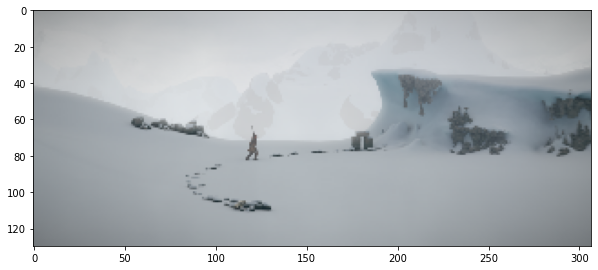

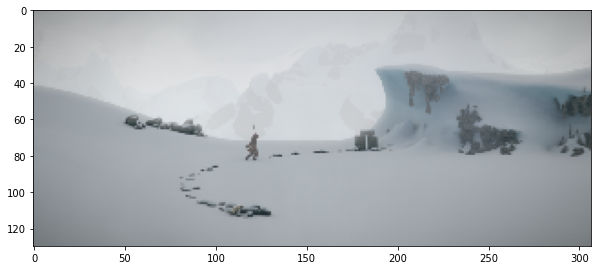

In [32]:
imshow(img1, is_gray=True)
imshow(img2, is_gray=True)

The algorithm begins with an **initial guess**, which may be
derived from prior information or may simply be a random field.
The iterative process consists of two phases: **propagation**, in which
coherence is used to disseminate good solutions to adjacent pixels
in the field; and **random search**, in which the current offset vector
is perturbed by multiple scales of random offsets

## 1. Initialization

The nearest-neighbor field can be initialized either by assigning random values to the field, or by using prior information. When initializing with random offsets, we use independent uniform samples
across the full range of image B.

1. Cut image A on patches.
1. For a_i patch generate random offsets on image B few times and calculate minimum l2 distance to patch on A.

In [33]:
import random

In [34]:
def get_patch_dist(source, dest, pos_s, pos_d, patch_size=3):
    y, x = pos_s
    y_d, x_d = pos_d
    a = source[:, y:y+patch_size, x:x+patch_size]
    b = dest[:, y_d:y_d+patch_size, x_d:x_d+patch_size]
    return torch.linalg.norm(a - b)

In [35]:
# # init patch centers for all possible coordinates from image A
# patch_size = 3

# C, H, W = img1.shape

# H_f = torch.randint(0, H, (H, W, 1))
# W_f = torch.randint(0, W, (H, W, 1))

# f = torch.cat([H_f, W_f], dim=2)
# f_d = torch.zeros(H, W, 1)

# pad = patch_size // 2
# img1_padded = torch.nn.functional.pad(img1, pad=(pad, pad, pad, pad, 0, 0), mode='constant',  value=0)
# img2_padded = torch.nn.functional.pad(img2, pad=(pad, pad, pad, pad, 0, 0), mode='constant',  value=0)

# for u in range(H):
#     for v in range(W):
#         _d = get_patch_dist(img1_padded, img2_padded, (u, v), f[u, v].tolist(), patch_size=patch_size)
#         f_d[u,v] = _d

In [36]:
def init(img1, img2, patch_size = 3):
    C, H, W = img1.shape

    H_f = torch.randint(0, H, (H, W, 1))
    W_f = torch.randint(0, W, (H, W, 1))

    f = torch.cat([H_f, W_f], dim=2)
    f_d = torch.zeros(H, W, 1)

    pad = patch_size // 2
    img1_padded = torch.nn.functional.pad(img1, pad=(pad, pad, pad, pad, 0, 0), mode='constant',  value=0)
    img2_padded = torch.nn.functional.pad(img2, pad=(pad, pad, pad, pad, 0, 0), mode='constant',  value=0)

    for u in range(H):
        for v in range(W):
            _d = get_patch_dist(img1_padded, img2_padded, (u, v), f[u, v].tolist(), patch_size=patch_size)
            f_d[u,v] = _d
    
    return img1_padded, img2_padded, f, f_d

In [37]:
_ = init(img1, img2, 3)

## 2. Propagation

In [38]:
def propagate(source, dest, f, f_d, pos, patch_size=3):
    y, x = pos
    center_offset = torch.tensor((y, x))
    left_offset = torch.tensor((y, max(0, x-1)))
    up_offset = torch.tensor((max(0, y-1), x))

    idx = torch.cat([center_offset, left_offset, up_offset]).view(-1, 2)

    min_idx = torch.argmin(f_d[idx[:, 0], idx[:, 1]])

    min_y, min_x = idx[min_idx].tolist()

    f[y, x] = f[min_y, min_x]

    f_d[y, x] = get_patch_dist(source, dest, (y, x), f[y, x].tolist(), patch_size=patch_size)
    return f, f_d

## 3. Random Search

In [44]:
def random_search(source, dest, f, f_d, pos, patch_size=3, alpha=.5):
    pad = patch_size // 2 
    y, x = pos
    C, H, W = dest.shape
    H -= patch_size
    W -= patch_size

    maped_y, maped_x = f[y, x].to(torch.int32).tolist()

    k = 1
    search_h, search_w = H * (alpha ** k), W * (alpha ** k)
    while search_h > 1 and search_w > 1:
        min_y = int(max(maped_y - search_h, pad))
        max_y = int(min(maped_y + search_w, H - pad))
        min_x = int(max(maped_x - search_h, pad))
        max_x = int(min(maped_x + search_w, W - pad))

        rand_idx = torch.randint(min_y, max_y, (1,)).item(), torch.randint(min_x, max_x, (1,)).item()
        rand_dist = get_patch_dist(source, dest, pos, rand_idx, patch_size=3)

        dist = f_d[y, x]

        if rand_dist < dist:
            f_d[y, x] = rand_dist
            f[y, x] = torch.tensor(rand_idx)

        k += 1
        search_h, search_w = H * (alpha ** k), W * (alpha ** k)
    
    return f, f_d

In [45]:
# axq = (100, 10)
# random_search(img1_padded, img2_padded, f, f_d, axq)

## 4. RUN?

In [46]:
from tqdm.auto import tqdm

In [47]:
def patchmatch(img1, img2, n_iters = 5, patch_size=3, alpha=.5):
    img1_padded, img2_padded, f, f_d = init(img1, img2, patch_size)

    _, total_y, total_x = img1.shape

    # print(total_y)
    # print(total_x)

    for i in tqdm(range(n_iters)):
        for y in tqdm(range(total_y)):
            for x in range(total_x):
                # print(">>>>>>>>>>>>>")
                # print("f.shape", f.shape)
                # print("f_d.shape", f_d.shape)
                f, f_d = propagate(img1_padded, img2_padded, f, f_d, (y, x), patch_size=patch_size)
                # print("f.shape", f.shape)
                # print("f_d.shape", f_d.shape)
                f, f_d = random_search(img1_padded, img2_padded, f, f_d, (y, x), patch_size=patch_size, alpha=alpha)
                # print("f.shape", f.shape)
                # print("f_d.shape", f_d.shape)
                # print("<<<<<<<<<<<<")

    return f, f_d

In [48]:
f, f_d = patchmatch(img1, img2)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

In [49]:
def show_reconstructed(f, img1, img2):
    _, total_y, total_x = img1.shape
    reconstructed = torch.zeros_like(img1)
    for y in tqdm(range(total_y)):
        for x in range(total_x):
            mapped_i, maped_j = f[y, x]
            reconstructed[:, y, x] = img2[:, mapped_i, maped_j]

    return reconstructed

In [50]:
reconstructed = show_reconstructed(f, img1, img2)

  0%|          | 0/130 [00:00<?, ?it/s]

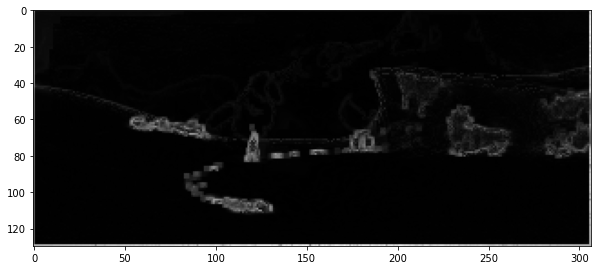

In [51]:
imshow(f_d.permute(2, 0, 1), is_gray=True)

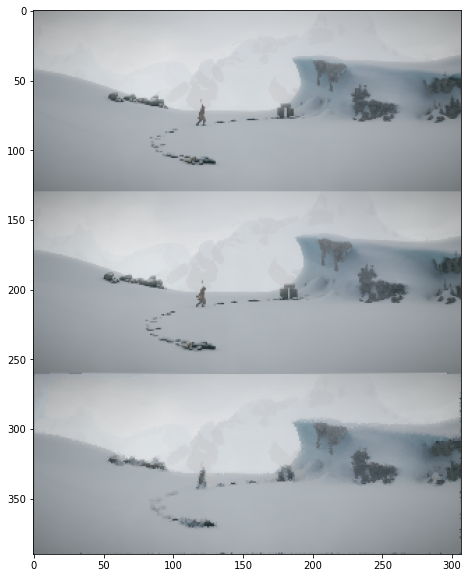

In [52]:
result_image = torch.cat([img1, img2, reconstructed], dim=1)
imshow(result_image, is_gray=False)